# Defining complex geometries using trimesh

`Tidy3D` offers four primitive geometric shapes: [Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Box.html), [Cylinder](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Cylinder.html), [Sphere](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Sphere.html), and [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html). An extensive array of intricate geometrical configurations can be defined from these fundamental building blocks by manipulating their properties and hierarchical arrangements. For instance, our tutorials on the [Luneburg lens waveguide size converter](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideSizeConverter/) and the [Fresnel lens](https://www.flexcompute.com/tidy3d/examples/notebooks/FresnelLens/) showcase the creation of curved surfaces through the strategic layering of cylindrical elements.

Beyond the in-built primitives, `Tidy3D` accommodates external geometrical specifications in either the [gds](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSImport/) or [stl](https://www.flexcompute.com/tidy3d/examples/notebooks/STLImport/) file formats, allowing users to import custom geometries created in their preferred design tools. Additionally, compatibility with external libraries like [gdstk](https://heitzmann.github.io/gdstk/) and [shapely](https://shapely.readthedocs.io/en/stable/index.html) opens the gateway to even more complex geometric possibilities. Using [gdstk](https://heitzmann.github.io/gdstk/) to create various waveguide structures has been demonstrated in various examples such as the [polarization splitter and rotator based on 90 degree bends](https://www.flexcompute.com/tidy3d/examples/notebooks/90BendPolarizationSplitterRotator/).

In this tutorial, we'll introduce an alternative avenue for crafting complex geometries using the [trimesh](https://trimsh.org/index.html) library. Through examples featuring a torus and an ellipsoid, we'll guide you through the process of defining a mesh structure that is directly usable in `Tidy3D` simulations.

Remember to install `Tidy3D` as `pip install "tidy3d[trimesh]"`, which will install optional dependencies needed for processing surface meshes.

In [1]:
import tidy3d as td
import trimesh
import numpy as np
import matplotlib.pyplot as plt

## Built-in Geometries 

First off all, [trimesh](https://trimsh.org/index.html) provides some [built-in geometries](https://trimsh.org/trimesh.creation.html#) such as ring (annulus), box, capsule, cone, cylinder, and so on. Let's create a ring as an example. 

After the mesh is created, we can visualize the mesh in 3D.

In [2]:
n_sections = 100 # how many sections to discretize the mesh

# create a ring mesh
ring_mesh = trimesh.creation.annulus(r_min=9, r_max=10, height=1, sections=n_sections)

# plot the mesh
ring_mesh.show()

To use this geometry in a Tidy3D simulation, we need to convert the mesh into a Tidy3D [TriangleMesh](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TriangleMesh.html) geometry. The `from_trimesh()` method conviently converts a mesh to a Tidy3D geometry. From there, you can further define Tidy3D [Structure](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html) and put it into a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html).

12:05:04 UTC WARNING: Plotting a 'TriangleMesh' may give inconsistent results if
             the mesh is not unionized. We recommend unionizing all meshes      
             before import. A 'PermittivityMonitor' can be used to check that   
             the mesh is loaded correctly.                                      

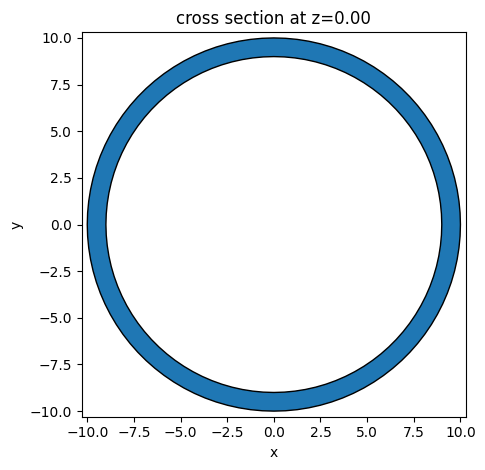

In [3]:
# define a tidy3d geometry from a mesh
ring_geo = td.TriangleMesh.from_trimesh(ring_mesh)

# plot a 2d cross section of the geometry
ring_geo.plot(z=0)
plt.show()

In addition, you can easily apply operations to a mesh such as translation and rotation. Here we demonstrate how to translate the previously created ring by a vector `(5, 10, 0)`. The resulting ring is centered at `(5, 10, 0)`.

             WARNING: Plotting a 'TriangleMesh' may give inconsistent results if
             the mesh is not unionized. We recommend unionizing all meshes      
             before import. A 'PermittivityMonitor' can be used to check that   
             the mesh is loaded correctly.                                      

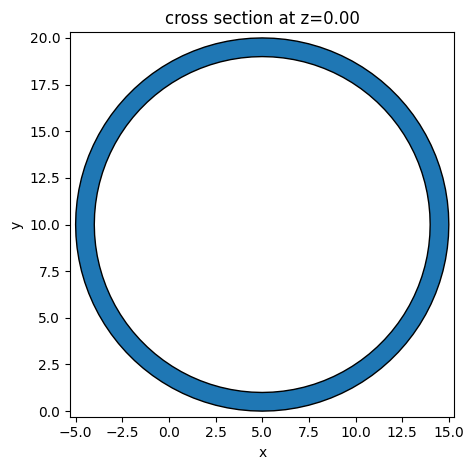

In [4]:
# translate the ring
ring_mesh.apply_translation([5,10,0])

# define a tidy3d geometry from a mesh
ring_geo = td.TriangleMesh.from_trimesh(ring_mesh)
ring_geo.plot(z=0)
plt.show()

In a grating coupler simulation, very often we want to use a tilted cylinder to model the fiber core at an angle. This can be done with the help of [trimesh](https://trimsh.org/index.html) too. First create a cylinder and then apply a rotation transformation to it. 

In [5]:
# create a cylinder
cylinder_mesh = trimesh.creation.cylinder(radius=2, height=10, sections=n_sections)

# apply rotation
rot_x = trimesh.transformations.rotation_matrix(np.radians(45), [1,0,0])
cylinder_mesh.apply_transform(rot_x)  

cylinder_mesh.show()

Convert the mesh into a Tidy3D geometry and plot the cross section views.

             WARNING: Plotting a 'TriangleMesh' may give inconsistent results if
             the mesh is not unionized. We recommend unionizing all meshes      
             before import. A 'PermittivityMonitor' can be used to check that   
             the mesh is loaded correctly.                                      

             WARNING: Plotting a 'TriangleMesh' may give inconsistent results if
             the mesh is not unionized. We recommend unionizing all meshes      
             before import. A 'PermittivityMonitor' can be used to check that   
             the mesh is loaded correctly.                                      

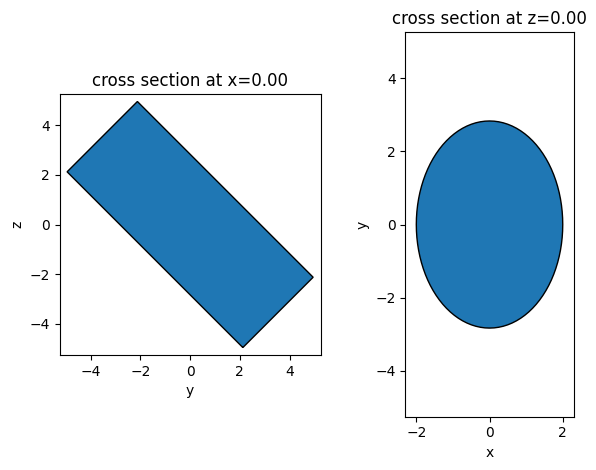

In [6]:
cylinder_geo = td.TriangleMesh.from_trimesh(cylinder_mesh)

fig, (ax1, ax2) = plt.subplots(1,2,tight_layout=True)
cylinder_geo.plot(x=0, ax=ax1)
cylinder_geo.plot(z=0, ax=ax2)
plt.show()

## Defining Complex Geometries from Vertices and Faces 

### Defining a Box 

Beyond the built-in geometries, much more complex geometries can be created in [trimesh](https://trimsh.org/index.html). To do so, we need to define the vertices and triangular faces for the geometry. 

First we demonstrate the idea by defining a simple box. The eight vertices of the box can be easily calculated given the width, height, and depth of the box. Then, a triangular face can be defined from three vertex indices. The box has six rectangular faces, which can be broken down into twelve triangular faces. Note that when defining the faces, we need to be careful about the order of the vertex indices to make sure the surface normal direction is consistent. 

In [7]:
def create_box(width, height, depth):
    
    # create vertices
    vertices = np.array([
        [+width/2, +height/2, +depth/2], # front top right
        [-width/2, +height/2, +depth/2], # front top left
        [-width/2, -height/2, +depth/2], # front bottom left
        [+width/2, -height/2, +depth/2], # front bottom right
        [+width/2, +height/2, -depth/2], # back top right
        [-width/2, +height/2, -depth/2], # back top left 
        [-width/2, -height/2, -depth/2], # back bottom left
        [+width/2, -height/2, -depth/2]  # back bottom right
    ])

    # define faces
    faces = np.array([
        [0,1,2], # front face
        [0,2,3], 
        [4,6,5], # back face
        [4,7,6],
        [0,4,5], # left face
        [0,5,1],
        [3,2,6], # right face
        [3,6,7],
        [1,5,6], # top face 
        [1,6,2],
        [0,3,7], # bottom face
        [0,7,4]
    ])
    
    return trimesh.Trimesh(vertices=vertices, 
                           faces=faces, 
                           process=False)

Create a box using the above function to verify that it works as expected.

In [8]:
box_mesh = create_box(1, 2, 3)
box_mesh.show()

### Defining a Torus

The previous box example is just to illustrate the idea of defining a mesh from vertices and faces. Next we showcase how to define a torus and a ellipsoid using the same approach. Both geometries are difficult to define natively in Tidy3D. 

Let's start with the torus. The vertices of the torus are given by 

\begin{equation*}
x = (R+rcos\phi)cos\theta
\end{equation*}
\begin{equation*}
y =( R+rcos\phi)sin\theta
\end{equation*}
\begin{equation*}
z =rsin\phi,
\end{equation*}

where $R$ is the radius of the major circle, $r$ is the radius of the minor circle, $\phi$ is the angle that parameterizes the minor circle and $\theta$ is the angle that parameterizes the major circle. `major_segments` and `minor_segments` control the number of segments in the major and minor circles, respectively.

In [9]:
def create_torus(major_radius, minor_radius, major_segments, minor_segments):
    # initialize empty lists to store the torus vertices and faces
    vertices = []
    faces = []

    # create vertices
    # loop over the major circle (the "doughnut" shape)
    for i in range(major_segments):
        # calculate the angle for the current major segment
        theta = i * 2 * np.pi / major_segments
        
        # loop over the minor circle (the "cross-section" of the doughnut)
        for j in range(minor_segments):
            # calculate the angle for the current minor segment
            phi = j * 2 * np.pi / minor_segments

            # calculate the x, y, z coordinates for the current vertex
            # the vertex lies on the smaller circle, which is then rotated around the origin
            x = (major_radius + minor_radius * np.cos(phi)) * np.cos(theta)
            y = (major_radius + minor_radius * np.cos(phi)) * np.sin(theta)
            z = minor_radius * np.sin(phi)

            # append the current vertex to the vertices list
            vertices.append([x, y, z])

    # create faces
    # loop over the major circle again to create faces
    for i in range(major_segments):
        # loop over the minor circle to create faces
        for j in range(minor_segments):
            # calculate indices for the next major and minor segments
            # use modulo to wrap-around at the end
            next_i = (i + 1) % major_segments
            next_j = (j + 1) % minor_segments

            # indices of vertices around the face, based on the current and next segments
            v1 = i * minor_segments + j
            v2 = next_i * minor_segments + j
            v3 = next_i * minor_segments + next_j
            v4 = i * minor_segments + next_j

            # create two triangular faces to form a quad face connecting these vertices
            # this covers the current segment of the torus
            faces.append([v1, v2, v4])
            faces.append([v2, v3, v4])

    # create mesh using the generated vertices and faces
    return trimesh.Trimesh(vertices=vertices, faces=faces)


Create a specific torus and plot it.

In [10]:
torus_mesh = create_torus(major_radius=2, minor_radius=0.3, major_segments=n_sections, minor_segments=n_sections)
torus_mesh.show()

### Defining an Ellipsoid

As the last example, we showcase how to define an ellipsoid. The vertices of an ellipsoid are given by

\begin{equation*}
x = a sin\theta cos\phi
\end{equation*}
\begin{equation*}
y=bsin\theta sin\phi
\end{equation*}
\begin{equation*}
z=ccos\theta,
\end{equation*}

where $a$, $b$, and $c$ are radii along the $x$, $y$, and $z$ axes, respectively. `u_segments` and `v_segments` control the number of segments in the latitude and longitude, respectively.


In [11]:
def create_ellipsoid(a, b, c, u_segments, v_segments):
    # initialize empty lists for vertices and faces
    vertices = []
    faces = []

    # create vertices
    for i in range(u_segments + 1):
        theta = i * np.pi / u_segments  # angle for the latitude (0 to pi)

        for j in range(v_segments + 1):
            phi = j * 2 * np.pi / v_segments  # angle for the longitude (0 to 2*pi)

            # compute vertex position using ellipsoidal equations
            x = a * np.sin(theta) * np.cos(phi)
            y = b * np.sin(theta) * np.sin(phi)
            z = c * np.cos(theta)

            vertices.append([x, y, z])

    # create faces
    for i in range(u_segments):
        for j in range(v_segments):
            # compute indices for vertices
            v1 = i * (v_segments + 1) + j
            v2 = (i + 1) * (v_segments + 1) + j
            v3 = (i + 1) * (v_segments + 1) + (j + 1)
            v4 = i * (v_segments + 1) + (j + 1)

            # create faces using the vertices
            faces.append([v1, v2, v3])
            faces.append([v1, v3, v4])

    # create mesh using the generated vertices and faces
    return trimesh.Trimesh(vertices=vertices, faces=faces)


Create a specific ellipsoid and plot it. 

In [12]:
ellipsoid_mesh = create_ellipsoid(a=1.3, b=0.4, c=0.3, u_segments=100, v_segments=100)
ellipsoid_mesh.remove_degenerate_faces()
ellipsoid_mesh.show()

/tmp/ipykernel_63383/271371735.py:2: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  ellipsoid_mesh.remove_degenerate_faces()


Lastly, we demonstrate again how to define Tidy3D [Structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html) from the mesh. We will put the previously defined torus and ellipsoid into a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) and plot the cross section of it. As expected, we see a ring and an ellipse in the plot.

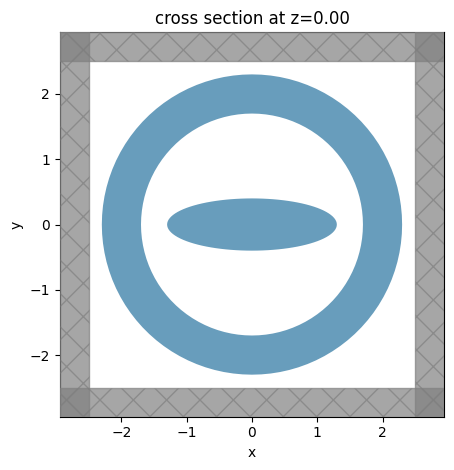

In [13]:
# define tidy3d geometries from the torus mesh and ellipsoid mesh
torus_geo = td.TriangleMesh.from_trimesh(torus_mesh)
ellipsoid_geo = td.TriangleMesh.from_trimesh(ellipsoid_mesh)

# define tidy3d structures from the geometries
torus_structure = td.Structure(geometry=torus_geo, medium=td.Medium(permittivity=2))
ellipsoid_structure = td.Structure(geometry=ellipsoid_geo, medium=td.Medium(permittivity=2))

# put the strcutures into a simulation
sim = td.Simulation(
    size=(5,5,5),
    structures=[torus_structure,ellipsoid_structure],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=25, wavelength=1),
    run_time=1e-12
                   )

# plot the cross section of the simualtion
sim.plot(z=0)
plt.show()